### 0.654
 - model: resnet7
 - frozen
 - 20 epochs - seed=1488 +
 - 20 epochs - seed = 42
 - fill '' with "scab"
 - MODEL_PATH = '/kaggle/input/effnet7-2-40-frozen-6cl/effnet7_2_6cl_frozen_40ep_42.h5'
 - labels without duplicates
 - sample_submission_copy = predict_test(threshold=False)

In [1]:
import os

import numpy as np
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

# warnings.filterwarnings("ignore")
warnings.filterwarnings(action='once')

import matplotlib.pyplot as plt

%matplotlib inline
# plots
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import sklearn
import tensorflow as tf
import tensorflow_addons as tfa
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    classification_report,
    f1_score,
    plot_confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import train_test_split
from tensorflow import keras
# from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import (
    AveragePooling2D,
    AvgPool2D,
    Conv2D,
    Dense,
    Flatten,
    GlobalAveragePooling2D,
    MaxPooling2D,
)
from tensorflow.keras.models import Sequential

# keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import notebook, tqdm

<frozen importlib._bootstrap>:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__


In [18]:
PATH = "/app/_data/"
BATCH_SIZE = 4
SEED1 = 1488
IMAGE_SIZE = (600, 600)
NUM_CLASSES = 6
INPUT_SHAPE = (600, 600, 3)
IMG_PATH = '/app/_data/train_images/666_bicubic/'
SEED2 = 42
MODEL_PATH = '/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5'

In [19]:
labels = pd.read_csv(PATH+'train_labels.csv')

In [20]:
sample_submission = pd.read_csv(PATH + "sample_submission.csv")

In [21]:
labels = labels.join(labels["labels"].str.get_dummies(sep=" "))

In [22]:
labels.head(1)

,image,labels,complex,frog_eye_leaf_spot,healthy,powdery_mildew,rust,scab
0,800113bb65efe69e.jpg,healthy,0,0,1,0,0,0


In [23]:
feature_columns = labels.columns[2:].tolist()
feature_columns

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

In [24]:
# train_df, valid_df = train_test_split(
#     labels, train_size=0.8, random_state=SEED1, stratify=labels["labels"]
# )

In [25]:
# train_df[train_df["powdery_mildew"] == 1].shape[0]

/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# for col in feature_columns:
#     print(col, train_df[train_df[col] == 1][col].sum())

In [27]:
# powdery_mildew = (
#     train_df[train_df["powdery_mildew"] == 1]
#     .sample(
#         n=(3000 - train_df[train_df["powdery_mildew"] == 1].shape[0]),
#         replace=True,
#         random_state=SEED,
#     )
# )
# rust = (
#     train_df[train_df["rust"] == 1]
#     .sample(
#         n=(3000 - train_df[train_df["rust"] == 1].shape[0]),
#         replace=True,
#         random_state=SEED,
#     )
# )
# complex_df = (
#     train_df[train_df["complex"] == 1]
#     .sample(
#         n=(3000 - train_df[train_df["complex"] == 1].shape[0]),
#         replace=True,
#         random_state=SEED,
#     )
# )

In [28]:
# train_df_new = pd.concat(
#     [
#         train_df,
#         powdery_mildew,
#         rust,
#         complex_df,
#     ],axis=0,ignore_index=True, 
# )

In [29]:
# train_df_new.shape
# train_df.shape

In [30]:
train_datagen = ImageDataGenerator(
    validation_split=0.2
)
train = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED1,
    interpolation="bicubic",
)

Found 14782 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 23 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [31]:
train2=ImageDataGenerator(validation_split=0.2).flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="training",
    seed=SEED2,
    interpolation="bicubic",
)

Found 14780 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 20 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [32]:
valid_datagen = ImageDataGenerator(
    validation_split=0.2,

)
valid = valid_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED1,
    classes=feature_columns,
    interpolation="bicubic",
    shuffle=True,

)

Found 3695 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:219: UserWarning: `classes` will be ignored given the class_mode="raw"
  warnings.warn('`classes` will be ignored given the class_mode="{}"'


In [33]:
valid2=ImageDataGenerator(validation_split=0.2,).flow_from_dataframe(
    dataframe=labels,
    directory=IMG_PATH,
    x_col="image",
    y_col=feature_columns,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="raw",
    subset="validation",
    seed=SEED2,
    classes=feature_columns,
    interpolation="bicubic",
    shuffle=True,

)

Found 3697 validated image filenames.


/usr/local/lib/python3.8/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [35]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH + "test_images/",
    x_col="image",
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,
    seed=SEED2,
    shuffle=False,
    interpolation="bicubic",
)

Found 3 validated image filenames.


In [36]:
def plot_curves(model, loss=False):
    df = pd.DataFrame(model.history)
    if loss:
        plt.figure(figsize=(12, 6))
        plt.title("loss")
        plt.plot(df.iloc[:, 0], label="loss")
        plt.plot(df.iloc[:, 5], label="val_loss")
        plt.legend()
        plt.show()
    else:
        plt.figure(figsize=(12, 20))
        plt.subplot(4, 1, 1)
        plt.title("accuracy")
        plt.plot(df.iloc[:, 1], label="accuracy")
        plt.plot(df.iloc[:, 6], label="val_accuracy")
        plt.legend()

        plt.subplot(4, 1, 2)
        plt.title("recall")
        plt.plot(df.iloc[:, 2], label="recall")
        plt.plot(df.iloc[:, 7], label="val_recall")
        plt.legend()

        plt.subplot(4, 1, 3)
        plt.title("precision")
        plt.plot(df.iloc[:, 3], label="precision")
        plt.plot(df.iloc[:, 8], label="val_precision")
        plt.legend()

        plt.subplot(4, 1, 4)
        plt.title("f1")
        plt.plot(df.iloc[:, 4], label="f1")
        plt.plot(df.iloc[:, 9], label="val_f1")
        plt.legend()
        plt.show();

In [37]:
data_augmentation = keras.Sequential(
    [
        keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        keras.layers.experimental.preprocessing.RandomHeight(0.1),
        keras.layers.experimental.preprocessing.RandomWidth(0.1),
        keras.layers.experimental.preprocessing.RandomRotation(0.15),
        keras.layers.experimental.preprocessing.RandomZoom(0.25, 0.25),
    ]
)

In [39]:
policy = keras.mixed_precision.experimental.Policy('mixed_float16')
keras.mixed_precision.experimental.set_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 5000, compute capability 7.5


In [41]:
callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss',
            patience=10, restore_best_weights=True, verbose=1),
        ]

In [43]:
inputs = keras.layers.Input(shape=INPUT_SHAPE)
x = data_augmentation(inputs)
model = keras.applications.EfficientNetB7(weights="imagenet", include_top=False,  input_tensor=x)
model.trainable = False

x = keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = keras.layers.Flatten(name="flatten")(x)
outputs = keras.layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [45]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=0.0005),
    metrics=['acc',
        keras.metrics.Recall(),
        keras.metrics.Precision(),
        tfa.metrics.F1Score(num_classes=NUM_CLASSES, average="micro"),
    ],
)

In [46]:
history = model.fit(
    train,
    validation_data=valid,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)

In [ ]:
history = model.fit(
    train2,
    validation_data=valid2,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    use_multiprocessing=True,
    callbacks = callbacks
)

In [48]:
# model.save("/app/_data/models/effnet7_2_6cl_frozen_40ep_42.h5")

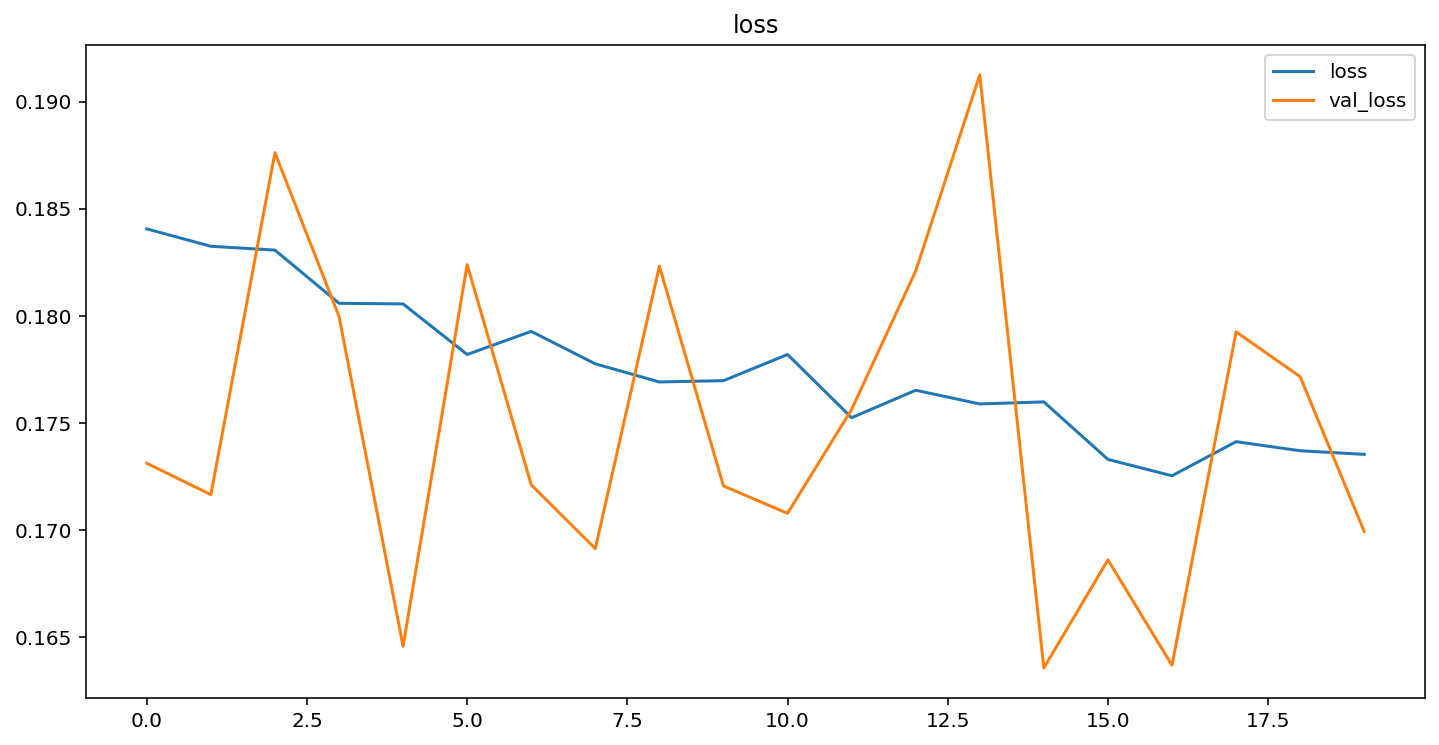

In [29]:
plot_curves(history, loss=True)

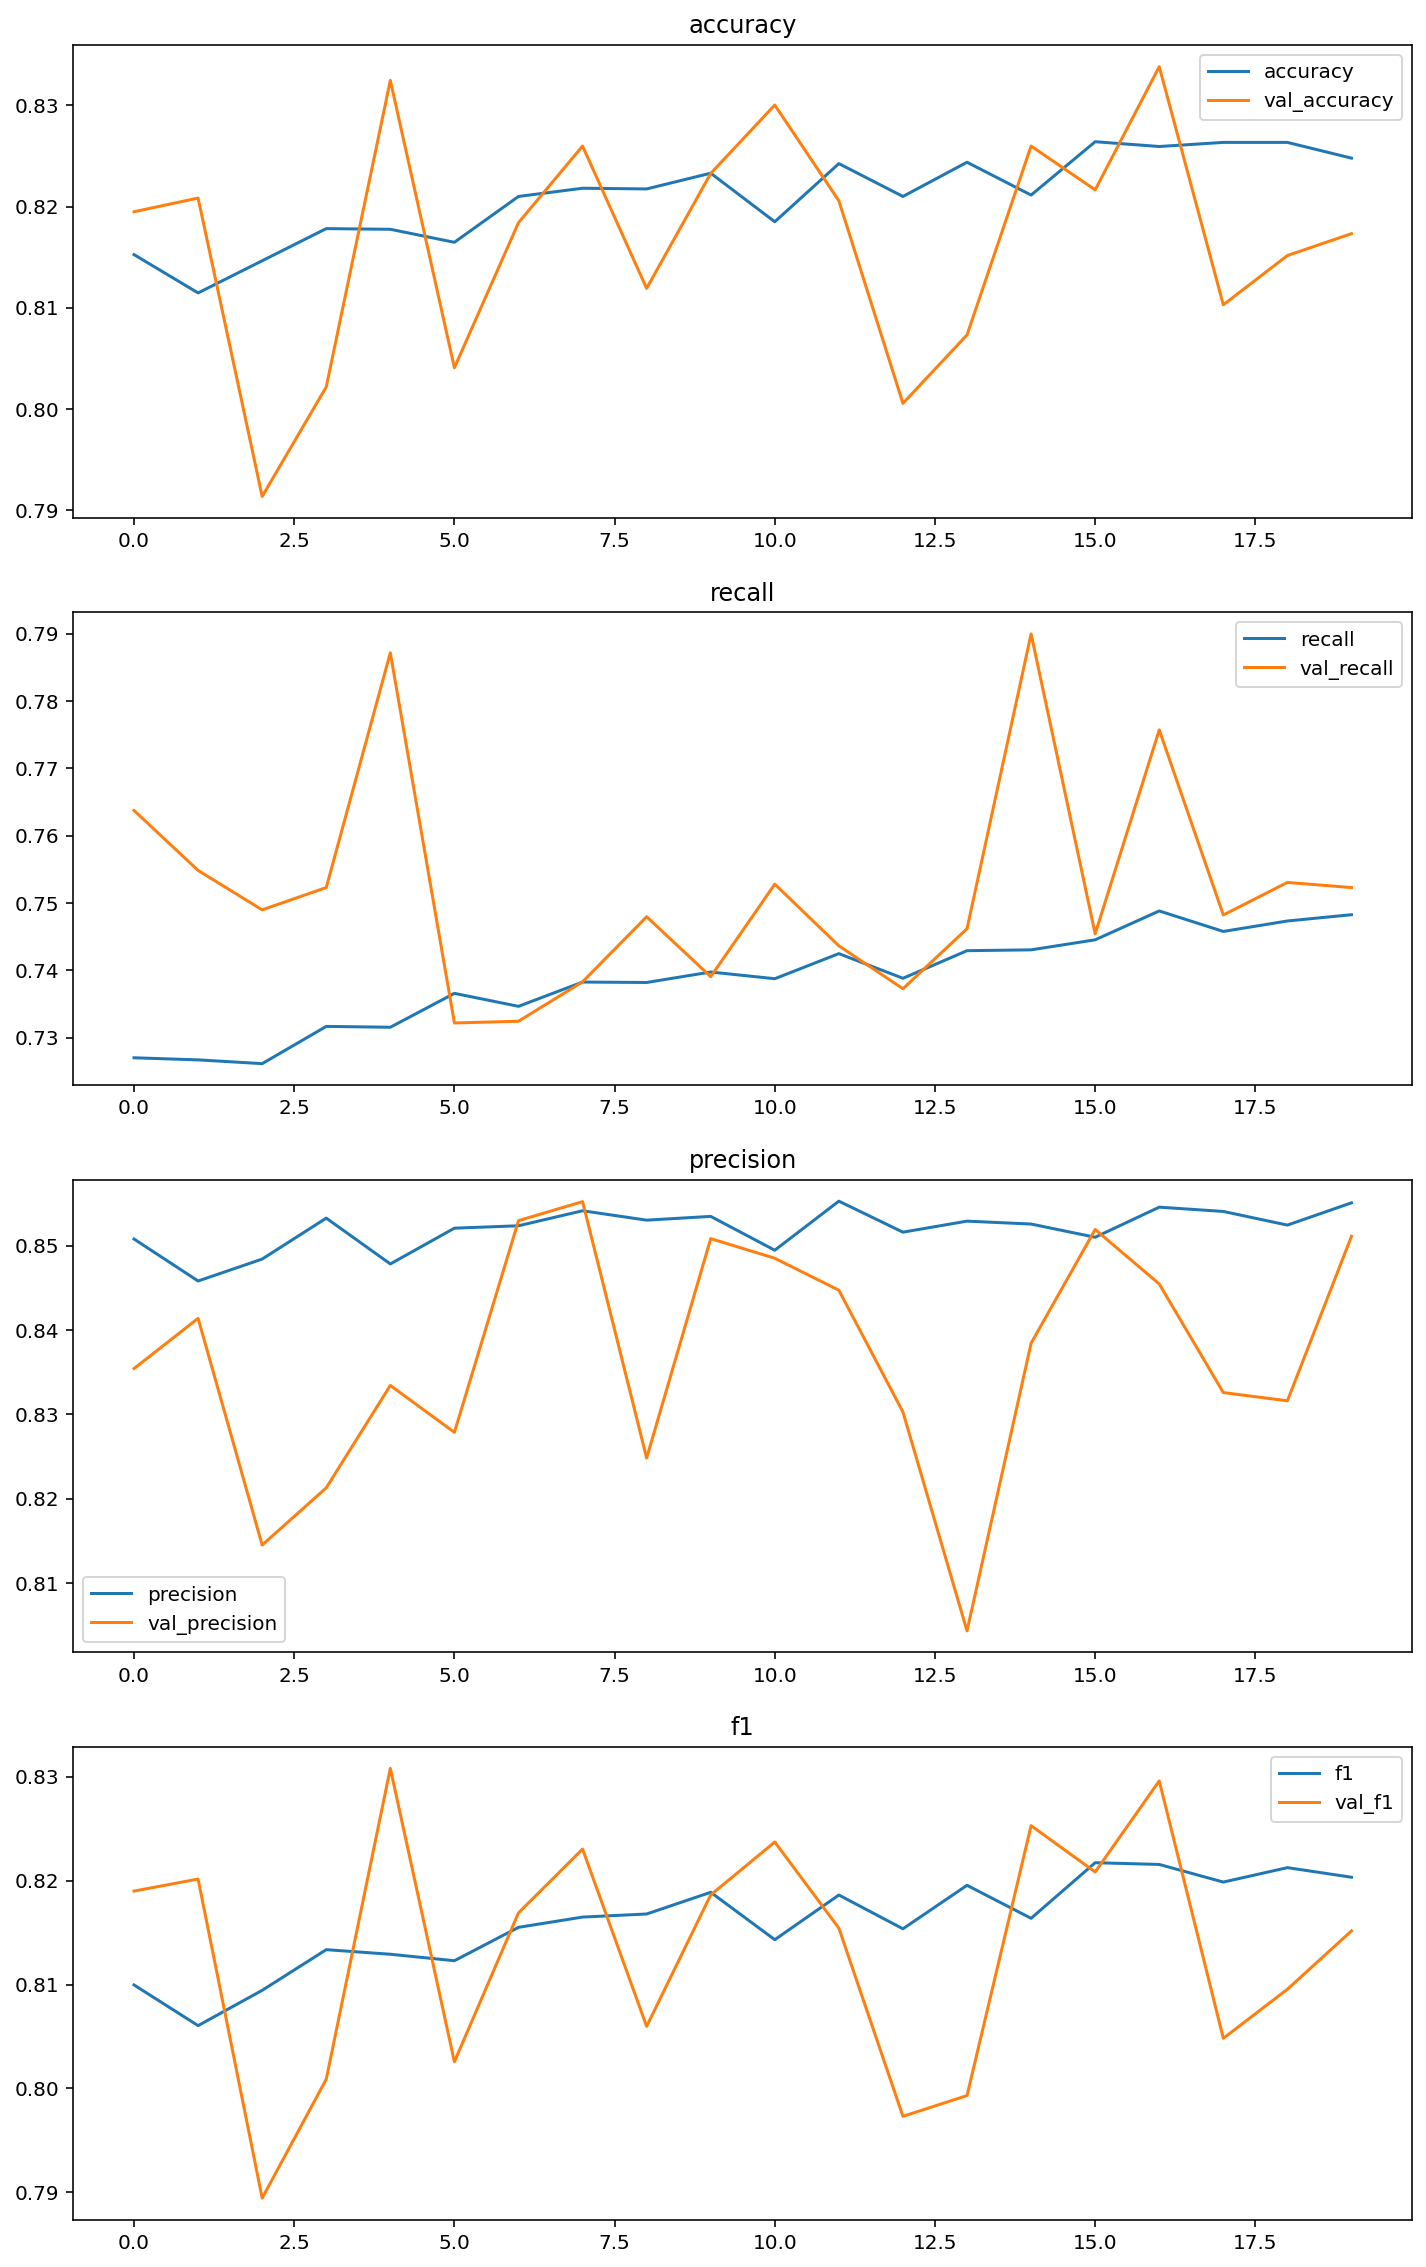

In [30]:
plot_curves(history)